In [1]:
import gymnasium
from gymnasium import spaces
import numpy as np
import pandas as pd

class RadarTaskSchedulerEnv(gymnasium.Env):
    def __init__(self, task_file="dataset.csv"):
        super(RadarTaskSchedulerEnv, self).__init__()

        self.tasks = pd.read_csv(task_file)
        self.current_task_idx = 0

        self.observation_space = spaces.Box(low=0, high=100, shape=(3,), dtype=np.int64)
        self.action_space = spaces.MultiDiscrete([3, 3, 3])  # [delay, compress, radar_choice]

    def reset(self,*, seed=None, options=None):
        super().reset(seed=seed)
        self.current_task_idx = 0
        obs= self._get_observation()
        return obs, {}

    def step(self, action):
        delay, compress, radar_choice = action
        task = self.tasks.iloc[self.current_task_idx]

        # tns = min(task['Deadline'], task['Request_Time'] + delay)
        # Pn = min(task['Max_Power'], task['Init_Power'] + compress)

        # task_dropped = (tns > task['Deadline']) or (Pn > task['Max_Power'])
        
        tns = task['Request_Time'] + delay
        Pn = task['Init_Power'] + compress

        task_dropped = (tns > task['Deadline']) or (Pn > task['Max_Power'])

        reward = 1 if not task_dropped else -1

        self.current_task_idx += 1
        done = self.current_task_idx >= len(self.tasks)

        if not done:
            next_obs = self._get_observation()
        else:
            next_obs = (0, 0, 0)  # or any dummy terminal observation
            
        info = { "task_dropped": task_dropped, "task_id": task["Task_ID"] if "Task_ID" in task else self.current_task_idx}


        return next_obs, reward, done, False, info

    def _get_observation(self):
        task = self.tasks.iloc[self.current_task_idx]
        return (int(task['Duration']), int(task['Deadline']), int(task['Init_Power']))


In [2]:
import numpy as np
from collections import defaultdict

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_decay, final_epsilon):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon  # Store the initial epsilon value
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.action_size = action_size
        self.state_size = state_size

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def decay_epsilon(self):
        # Decay epsilon after each episode and ensure it doesn't go below the final epsilon value
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.final_epsilon)

Episode 50 — Total Reward: 70 — Tasks Dropped: 15 — Epsilon: 0.696
Episode 100 — Total Reward: 82 — Tasks Dropped: 9 — Epsilon: 0.539
Episode 150 — Total Reward: 78 — Tasks Dropped: 11 — Epsilon: 0.417
Episode 200 — Total Reward: 82 — Tasks Dropped: 9 — Epsilon: 0.323
Episode 250 — Total Reward: 84 — Tasks Dropped: 8 — Epsilon: 0.250
Episode 300 — Total Reward: 96 — Tasks Dropped: 2 — Epsilon: 0.193
Episode 350 — Total Reward: 96 — Tasks Dropped: 2 — Epsilon: 0.149
Episode 400 — Total Reward: 100 — Tasks Dropped: 0 — Epsilon: 0.116
Episode 450 — Total Reward: 98 — Tasks Dropped: 1 — Epsilon: 0.100
Episode 500 — Total Reward: 90 — Tasks Dropped: 5 — Epsilon: 0.100
Training complete!


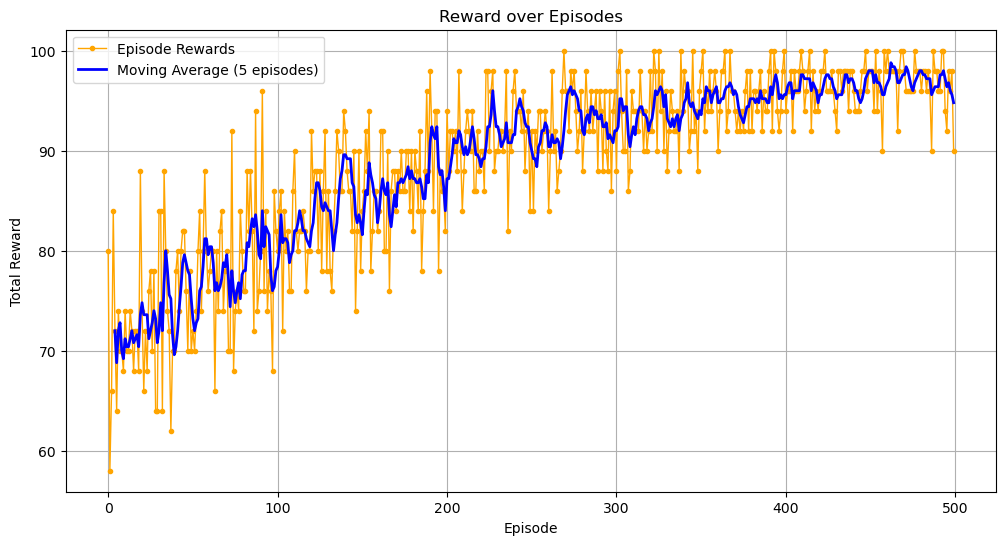

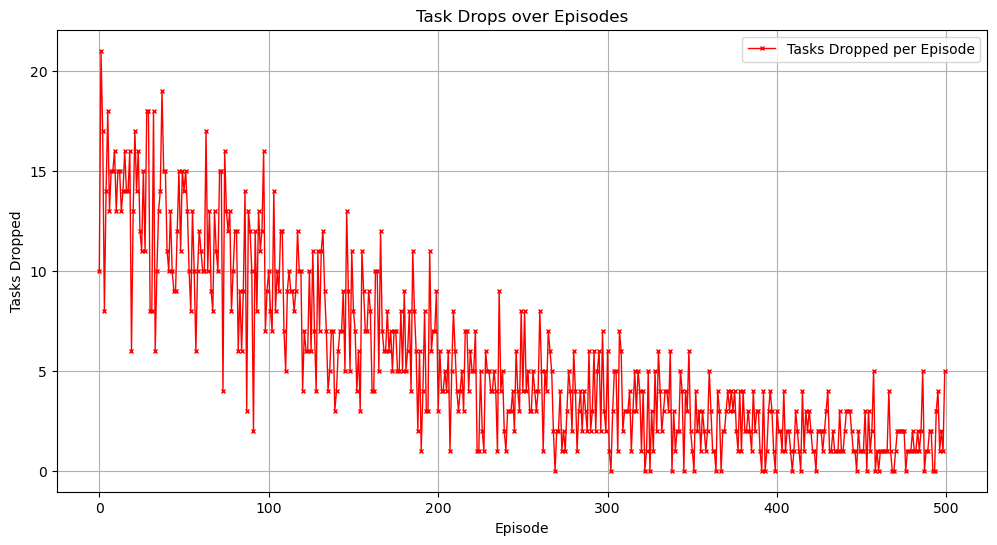

In [3]:
import matplotlib.pyplot as plt
import numpy as np


env = RadarTaskSchedulerEnv("dataset.csv")
agent = QLearningAgent(
    state_size=3,
    action_size=27,
    alpha=0.15,
    gamma=0.95,
    epsilon=0.9,
    epsilon_decay=0.95,
    final_epsilon=0.1
)

# Decode function for action
def decode_action(index):
    delay = index // 9
    compress = (index % 9) // 3
    radar = index % 3
    return [delay, compress, radar]

# Training parameters
episodes = 500
reward_log = []
task_drop_log = []  # New: to track drops
epsilon_decay_every = 10  # decay epsilon every 10 episodes

# Training loop
for episode in range(episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    task_drops = 0  # New: drops per episode

    while not done:
        action_index = agent.choose_action(state)
        action = decode_action(action_index)
        next_state, reward, done, _, info = env.step(action)
        
        # Update Q-table
        agent.update_q_value(state, action_index, reward, next_state)

        state = next_state
        total_reward += reward

        # Track if task dropped
        if info.get('task_dropped', False):
            task_drops += 1

    reward_log.append(total_reward)
    task_drop_log.append(task_drops)

    # Decay epsilon every 10 episodes (using the agent's method)
    if (episode + 1) % epsilon_decay_every == 0:
        agent.decay_epsilon()

    # Print progress every 50 episodes
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode+1} — Total Reward: {total_reward} — Tasks Dropped: {task_drops} — Epsilon: {agent.epsilon:.3f}")

print("Training complete!")

# Plotting Rewards
window_size = 5
moving_avg = np.convolve(reward_log, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12,6))
plt.plot(reward_log, label='Episode Rewards', color='orange', marker='o', markersize=3, linewidth=1)
plt.plot(range(window_size-1, len(reward_log)), moving_avg, label=f'Moving Average ({window_size} episodes)', color='blue', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Task Drops
plt.figure(figsize=(12,6))
plt.plot(task_drop_log, label='Tasks Dropped per Episode', color='red', marker='x', markersize=3, linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Tasks Dropped')
plt.title('Task Drops over Episodes')
plt.legend()
plt.grid(True)
plt.show()